# PSB injection bump in Xsuite - thin model for tracking

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

###  Load line from previous notebook

In [3]:
# Reload
line_thick = xt.Line.from_json('psb_03_with_chicane_corrected.json')
line_thick.build_tracker()

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


### Make a copy to preserve the thick model for reference

In [4]:
line = line_thick.copy()
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Slice all thick elements

In [5]:
from xtrack.slicing import Strategy, Teapot

line.discard_tracker()

line.slice_thick_elements(
    slicing_strategies=[
        Strategy(slicing=Teapot(1)),  # Default
        Strategy(slicing=Teapot(2), element_type=xt.Bend),
        Strategy(slicing=Teapot(10), element_type=xt.Quadrupole),
    ]
)

line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Check Q, Q' and beta beating at t=0

In [6]:
tw_thin = line.twiss()
tw_thick = line_thick.twiss()
print(f'Qx: thick {tw_thin.qx:.4f} thin {tw_thick.qx:.4f}, diff {tw_thin.qx-tw_thick.qx:.4e}')
print(f'Qy: thick {tw_thin.qy:.4f} thin {tw_thick.qy:.4f}, diff {tw_thin.qy-tw_thick.qy:.4e}')
print(f"Q'x: thick {tw_thin.dqx:.4f} thin {tw_thick.dqx:.4f}, diff {tw_thin.dqx-tw_thick.dqx:.4f}")
print(f"Q'y: thick {tw_thin.dqy:.4f} thin {tw_thick.dqy:.4f}, diff {tw_thin.dqy-tw_thick.dqy:.4f}")

bety_interp = np.interp(tw_thick.s, tw_thin.s, tw_thin.bety)
print(f"Max beta beat: {np.max(np.abs(tw_thick.bety/bety_interp - 1)):.4e}")

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Qx: thick 4.4008 thin 4.4000, diff 7.6462e-04
Qy: thick 4.4497 thin 4.4500, diff -3.3028e-04
Q'x: thick -3.7358 thin -3.5656, diff -0.1703
Q'y: thick -7.3215 thin -7.1498, diff -0.1718
Max beta beat: 1.4614e-04


### Compare tune and chromaticity during chicane collapse

In [7]:
# Comparison with correction off
for ll in [line, line_thick]:
    ll.vars['on_chicane_k0'] = 1
    ll.vars['on_chicane_k2'] = 1
    ll.vars['on_chicane_beta_corr'] = 0
    ll.vars['on_chicane_tune_corr'] = 0

In [8]:
t_test = np.linspace(0, 6e-3, 100)

qx_thick = []; qy_thick = []; dqx_thick = []; dqy_thick = []
qx_thin = []; qy_thin = []; dqx_thin = []; dqy_thin = [] 
bety_at_scraper_thin = []; bety_at_scraper_thick = []
x_at_foil_thick = []; x_at_foil_thin = []

for ii, tt in enumerate(t_test):
    print(f'Check at t = {tt*1e3:.2f} ms   ', end='\r', flush=True)
    
    line_thick.vars['t_turn_s'] = tt
    line.vars['t_turn_s'] = tt

    tw_thick = line_thick.twiss()
    
    x_at_foil_thick.append(tw_thick['x', 'bi1.tstr1l1'])
    bety_at_scraper_thick.append(tw_thick['bety', 'br.stscrap22'])
    qx_thick.append(tw_thick.qx)
    qy_thick.append(tw_thick.qy)
    dqx_thick.append(tw_thick.dqx)
    dqy_thick.append(tw_thick.dqy)

    tw_thin = line.twiss()
    
    x_at_foil_thin.append(tw_thin['x', 'bi1.tstr1l1'])
    bety_at_scraper_thin.append(tw_thin['bety', 'br.stscrap22'])
    qx_thin.append(tw_thin.qx)
    qy_thin.append(tw_thin.qy)
    dqx_thin.append(tw_thin.dqx)
    dqy_thin.append(tw_thin.dqy)

<IPython.core.display.Javascript object>


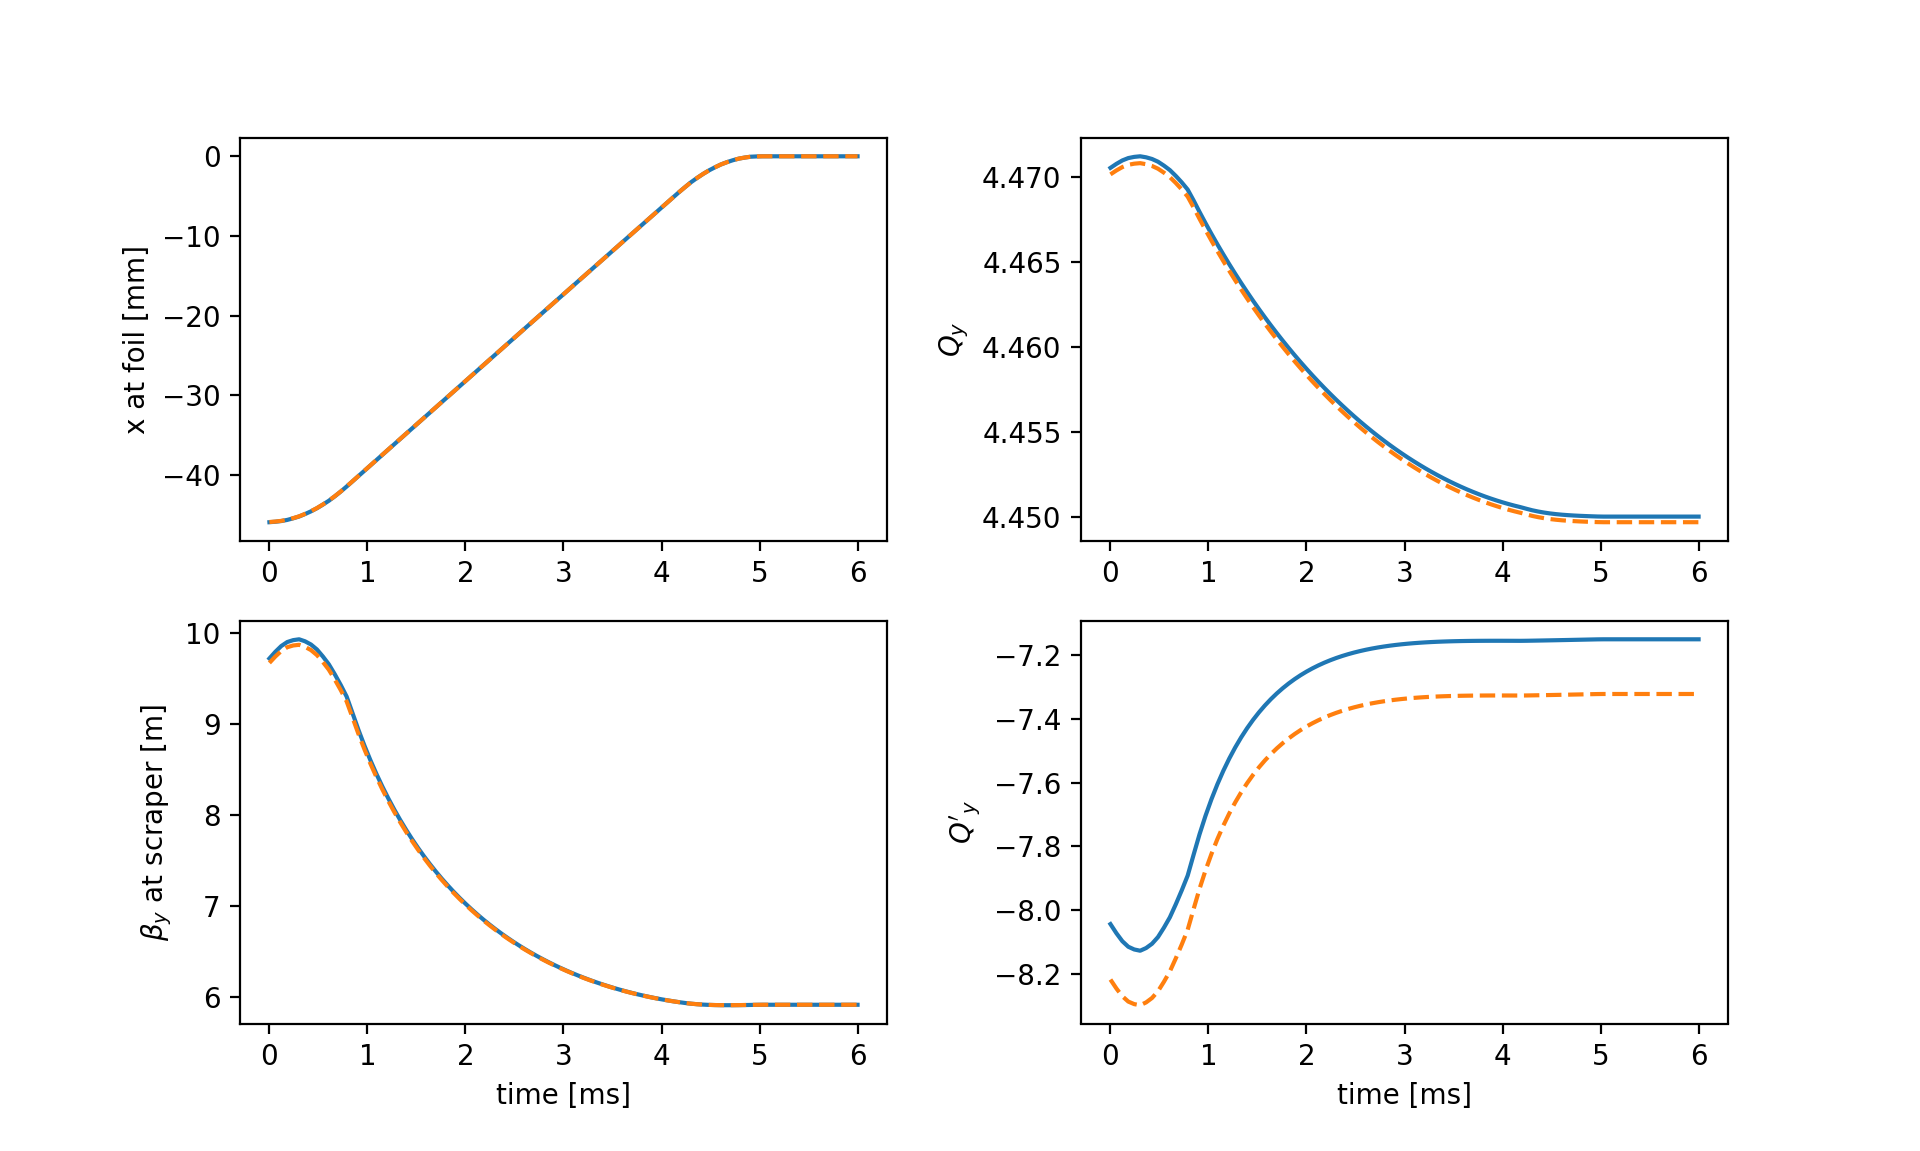

In [9]:
plt.figure(2, figsize=(6.4*1.5, 4.8*1.2))

sp1 = plt.subplot(2,2,1)
plt.plot(t_test*1e3, np.array(x_at_foil_thick)*1e3, '-', label='thick')
plt.plot(t_test*1e3, np.array(x_at_foil_thin)*1e3, '--', label='thin')
plt.ylabel('x at foil [mm]')

sp2 = plt.subplot(2,2,2, sharex=sp1)
plt.plot(t_test*1e3, qy_thick, '-', label='thick')
plt.plot(t_test*1e3, qy_thin, '--', label='thin')
plt.ylabel(r'$Q_y$')

sp3 = plt.subplot(2,2,3, sharex=sp1)
plt.plot(t_test*1e3, bety_at_scraper_thick, '-', label='thick')
plt.plot(t_test*1e3, bety_at_scraper_thin, '--', label='thin')
plt.ylabel(r'$\beta_y$ at scraper [m]')
plt.xlabel('time [ms]')

sp2 = plt.subplot(2,2,4, sharex=sp1)
plt.plot(t_test*1e3, dqy_thick, '-', label='thick')
plt.plot(t_test*1e3, dqy_thin, '--', label='thin')
plt.ylabel(r"$Q'_y$")
plt.xlabel('time [ms]')
plt.subplots_adjust(hspace=.2, wspace=.3)

-------